In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mphelper import ProcessWrapPool
import itertools
from biodatatools.utils.common import json_load
from collections import defaultdict
from matplotlib.patches import Rectangle, Patch
from biodata.delimited import DelimitedWriter
import subprocess
import seaborn as sns
from pathlib import Path

In [3]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [4]:
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# Illustration of core promoter motifs

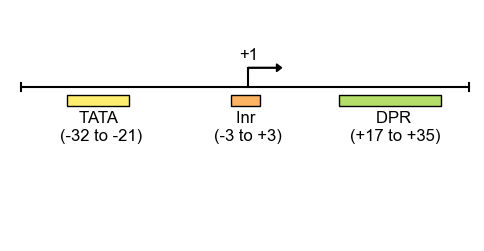

In [15]:
fig, ax = plt.subplots(figsize=(6,3))
plt.axis('off')
ax.plot([-39,40], [0,0], c="#000000")
ax.set_xlim([-41,41])
ax.set_ylim([-4,2])
ax.plot([-39,-39], [-0.1,0.1], c="#000000")
ax.plot([40,40], [-0.1,0.1], c="#000000")
ax.plot([1,1], [0,0.5], c="#000000")

# +1
ax.arrow(1, 0.5, 5, 0, head_width=0.2, head_length=0.9, facecolor="k", width=0.02)
ax.text(x=1, y=0.7, s="+1", fontsize=bfontsize, ha="center")

# Inr
ax.add_patch(Rectangle((-2, -0.5), 5, 0.3,
			 edgecolor = "#000000",
			 facecolor = "#fdb462",
			 fill=True))
ax.text(x=1, y=-1.4, s="Inr \n(-3 to +3)", fontsize=bfontsize, ha="center")
# TATA
ax.add_patch(Rectangle((-31, -0.5), 11, 0.3,
			 edgecolor = "#000000",
			 facecolor = "#ffed6f",
			 fill=True))
ax.text(x=-25, y=-1.4, s="TATA \n(-32 to -21)", fontsize=bfontsize, ha="center")
# DPR
ax.add_patch(Rectangle((17, -0.5), 18, 0.3,
			 edgecolor = "#000000",
			 facecolor = "#b3de69",
			 fill=True))
ax.text(x=27, y=-1.4, s="DPR \n(+17 to +35)", fontsize=bfontsize, ha="center")
outputfile = PROJECT_DIR_o + "figures/Fig2c.top.pdf"
plt.savefig(outputfile, bbox_inches="tight", dpi=300, transparent=True)

# Scan for motifs

In [5]:
s = "C1"
ds = ["distal", "proximal"]

In [6]:
seqs = json_load(f"{PROJECT_DIR_o}temp/{s}_TSS_seqs.json")

## Inr

In [7]:
# Inr (-3~+3): BBCABW

def is_Inr(subseq):
	B = ["G", "T", "C"]
	W = ["A", "T"]
	return subseq[0] in B and subseq[1] in B and subseq[2] == "C" and subseq[3] == "A" and subseq[4] in B and subseq[5] in W

In [8]:
n_motifs = {}
for k in seqs:
	n_motifs[k] = defaultdict(int)
	for seq in seqs[k]:
		subseq = seq[50-3:50+3]
		if is_Inr(subseq):
			n_motifs[k]["Inr"] += 1

## TATA box and DPR

### Query sequences

In [9]:
# Query sequence data must be formatted as follows. 
# The variable names are V1 to V12 for SVRTATA (corresponding to positions −32 to −21) and 
# V1 to V19 for SVRc and SVRb (corresponding to positions from +17 to +35). 

def get_input_seqs(seqs, outputfile, motif):
	with DelimitedWriter(outputfile) as dw:
		for seq in seqs[k]:
			if motif == "TATA":
				subseq = seq[50-32:50-20]
			else:
				subseq = seq[50+16:50+35]
			dw.write([subseq])

In [9]:
ms = ["TATA", "DPR"]

In [11]:
for m, k in itertools.product(ms, seqs):
	outputfile = f"{PROJECT_DIR_o}SVR/{m}_{k}_seq.txt"
	get_input_seqs(seqs, outputfile, m)

### Run prediction models

In [12]:
def predict(motif, inputfile, outputfile):
	script = f"{PROJECT_DIR_s}SVR/GSE139635_SVRpredict.R"
	if motif == "TATA":
		model = f"{PROJECT_DIR_s}SVR/GSE139635_SVRtata_TATAbox.model"
	else:
		model = f"{PROJECT_DIR_s}SVR/GSE139635_SVRb_DPR.model"
	commands = ["Rscript", script,
			   "-i", inputfile,
			   "-m", model,
			   "-o", outputfile
			  ]
	subprocess.run(" ".join(commands), shell=True)

In [21]:
pwpool = ProcessWrapPool(len(ms)*len(seqs))

for m, k in itertools.product(ms, seqs):
	inputfile = f"{PROJECT_DIR_o}SVR/{m}_{k}_seq.txt"
	outputfile = f"{PROJECT_DIR_o}SVR/{m}_{k}_seq.predict"
	pwpool.run(predict, args=[m, inputfile, outputfile])

In [22]:
len(pwpool.finished_tasks)

12

In [23]:
pwpool.close()

In [10]:
# Sequence variants with SVRb score ≥ 2 and SVRTATA score ≥ 1 are typically at least about 6 times more active than an inactive sequence, and are thus designated as “active”. 

cutoffs = {"TATA": 1, "DPR": 2}

In [11]:
for m, k in itertools.product(ms, seqs):
	inputfile = f"{PROJECT_DIR_o}SVR/{m}_{k}_seq.predict"
	df = pd.read_table(inputfile)
	df2 = df[df["SVR_score"]>=cutoffs[m]]
	n_motifs[k][m] = len(df2)

## Comparison of fractions

In [12]:
results = []

order = ["TATA", "Inr", "DPR"] 
for k in n_motifs:
	for m in order:
		d = k.split("_")[-1]
		if len(k.split("_")) == 3:
			k2 = f"{k.split('_')[0]} ({k.split('_')[1]})"
		else:
			k2 = k.split('_')[0]
		results.append([m, d, k2, n_motifs[k][m]/len(seqs[k])*100])
df_prop = pd.DataFrame(results, columns=["Motif", "Group1", "Group2", "Proportion"])
df_prop.head(2)

,Motif,Group1,Group2,Proportion
0,TATA,distal,Divergent (maxTSS),15.755703
1,Inr,distal,Divergent (maxTSS),30.026141


In [13]:
def plot_proportions(d, outputfile):
	fig, ax = plt.subplots(figsize=(5.5,3))
	df_prop2 = df_prop[df_prop["Group1"]==d]
	g = sns.barplot(data=df_prop2, x="Motif", y="Proportion", 
					hue="Group2", 
					palette=["#6a51a3", "#bcbddc", "#fccde5"], ax=ax)
	g.spines[["right", "top"]].set_visible(False)
	g.legend(title="", loc="upper left", fontsize=sfontsize, frameon=False, bbox_to_anchor=(0,1))
	
	g.set_ylim([0,50])
	g.set_ylabel("TREs with motifs (%)", fontsize=bfontsize)
	g.tick_params(axis="y", labelsize=sfontsize)
	
	g.set_xlabel("")
	g.tick_params(axis="x", labelsize=bfontsize)
	
	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

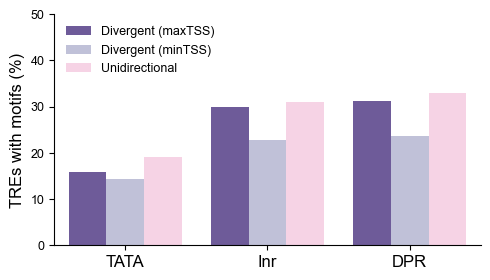

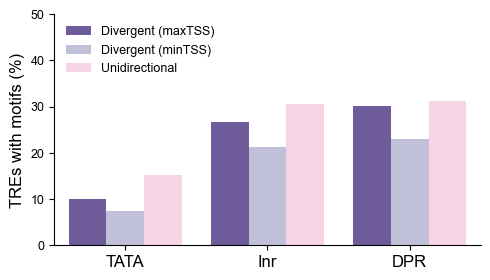

In [15]:
for d in ds:	
	folder = "figures/" if d == "distal" else "other_figures/"
	outputfile = f"{PROJECT_DIR_o}{folder}Fig2c.bottom.pdf"
	plot_proportions(d, outputfile)